In [ ]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import shap
import time
import pytorch_grad_cam

from WallWorld import WallWorld
from DqnAgent import DqnAgent

if __name__ == "__main__":

    # Config
    max_steps=500_000

    # WallWorld
    render_mode=None
    size=7
    agentSpawn = None
    maxSteps=200
    stepLoss=0
    chestSpawnCoordinates=np.array([[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [0, 6],
                                    [1, 0], [1, 1], [1, 2], [1, 3], [1, 4], [1, 5], [1, 6],
                                    [2, 0], [2, 1], [2, 2],         [2, 4], [2, 5], [2, 6]])
    wallCoordinates=      np.array([[3, 0], [3, 1], [3, 2],         [3, 4], [3, 5], [3, 6],])
    agentSpawnCoordinates=np.array([[4, 0],                                         [4, 6],
                                    [5, 0],                                         [5, 6],
                                    [6, 0],                                         [6, 6]])
    randomWalls=0
    redChestCoordinates=None
    greenChestCoordinates=None
    keyCoordinates=None
    randomredChests=1
    randomgreenChests=1
    randomkeys=0
    redChestReward=-1 # Don't change this
    greenChestReward=1 # Don't change this
    # Explaination:
    # terminated with 1 reward ---> green chest: 1
    # terminated with 0 reward ---> red chest:  -1
    # truncated                 --> no chest:    0
    
    # Agent
    batch_size=64
    lr=0.001
    gamma=0.95
    epsilon_start=1
    epsilon_min=0.05
    epsilon_decay=200_000 # 50_000 at 3000 episodes
    tau=0.0005 # Was 0.005
    replayBuffer=100_000

    env = WallWorld(render_mode=None,
                    size=size, agentSpawn=agentSpawn,
                    stepLoss=stepLoss, maxSteps=maxSteps,
                    wallCoordinates=wallCoordinates,
                    randomWalls=randomWalls,
                    redChestCoordinates=redChestCoordinates,
                    greenChestCoordinates=greenChestCoordinates,
                    keyCoordinates=keyCoordinates,
                    redChestReward=redChestReward,
                    greenChestReward=greenChestReward,
                    randomredChests=randomredChests,
                    randomgreenChests=randomgreenChests,
                    randomkeys=randomkeys,
                    agentSpawnCoordinates=agentSpawnCoordinates,
                    chestSpawnCoordinates=chestSpawnCoordinates)
    observation, _ = env.reset()
    agent = DqnAgent(env.action_space, observation,
        batch_size=batch_size,
        lr=lr,
        gamma=gamma,
        epsilon_start=epsilon_start,
        epsilon_min=epsilon_min,
        epsilon_decay=epsilon_decay,
        tau=tau,
        replayBuffer=replayBuffer)
    
    maxSteps = 30 #????
    show_env = WallWorld(render_mode="human",
                    size=size, agentSpawn=agentSpawn,
                    stepLoss=stepLoss, maxSteps=maxSteps,
                    wallCoordinates=wallCoordinates,
                    randomWalls=randomWalls,
                    redChestCoordinates=redChestCoordinates,
                    greenChestCoordinates=greenChestCoordinates,
                    keyCoordinates=keyCoordinates,
                    redChestReward=redChestReward,
                    greenChestReward=greenChestReward,
                    randomredChests=randomredChests,
                    randomgreenChests=randomgreenChests,
                    randomkeys=randomkeys,
                    agentSpawnCoordinates=agentSpawnCoordinates,
                    chestSpawnCoordinates=chestSpawnCoordinates)

    modelNames = ["r00_g10_1500k",
              "r01_g10_1500k",
              "r02_g10_1500k",
              "r03_g10_1500k",
              "r04_g10_1500k",
              "r05_g10_1500k",
              "r06_g10_1500k",
              "r07_g10_1500k",
              "r08_g10_1500k",
              "r09_g10_1500k",
              "r10_g00_1500k",
              "r10_g01_1500k",
              "r10_g02_1500k",
              "r10_g03_1500k",
              "r10_g04_1500k",
              "r10_g05_1500k",
              "r10_g06_1500k",
              "r10_g07_1500k",
              "r10_g08_1500k",
              "r10_g09_1500k",
              "r10_g10_1500k"]

pygame 2.6.0 (SDL 2.28.4, Python 3.12.2)
Hello from the pygame community. https://www.pygame.org/contribute.html


Model loaded: C:/Projects/public/XAI_Master/models/r10_g10_1500k.pth
tensor([[0.6655, 0.7006, 0.7336, 0.7372]])
State shape: torch.Size([7, 7, 3])
Right: 0.665, Down: 0.701, Left: 0.734, Up: 0.737, 

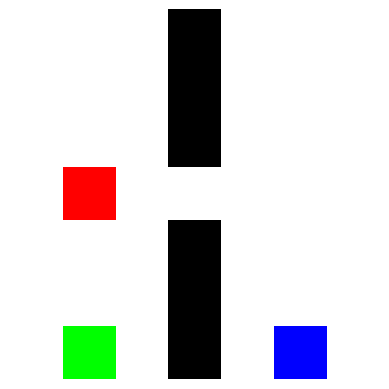

In [ ]:
agent.load_model_weights(f"C:/Projects/public/XAI_Master/models/r10_g10_1500k.pth")
state, _ = env.reset()
state = torch.tensor(state, dtype=torch.float32, device=agent.device).unsqueeze(0)
actions = agent.predict(state)

def plotState(state):
    image = state.squeeze().numpy().transpose((1, 0, 2))
    plt.imshow(image, interpolation='nearest')
    plt.axis('off')
    plt.show()

def printActions(actions):
    action_to_direction = {0: 'Right', 1: 'Down', 2: 'Left', 3: 'Up'}
    for i, action in enumerate(actions[0]):
        print(f"{action_to_direction[i]}: {action:.3f}", end=", ")

printActions(actions)
plotState(state)


In [ ]:
def compute_heatmap(model,img):
  model.eval()
  # compute logits from the model
  logits = model(img)
  # model's prediction 
  pred = logits.max(-1)[-1]
  # activations from the model
  activations = image_to_heatmaps(img)
  # compute gradients with respect to the model's most confident prediction
  logits[0, pred].backward(retain_graph=True)
  # average gradients of the featuremap 
  pool_grads = model.features[-3].weight.grad.data.mean((0,2,3))
  # multiply each activation map with corresponding gradient average
  for i in range(activations.shape[1]):
    activations[:,i,:,:] *= pool_grads[i]
  # calculate mean of weighted activations
  heatmap = torch.mean(activations, dim=1)[0].cpu().detach()
  return heatmap, pred
def upsampleHeatmap(map, image):
  # permute image
  image = image.squeeze(0).permute(1, 2, 0).cpu().numpy()
  # maximum and minimum value from heatmap
  m, M = map.min(), map.max()
  # normalize the heatmap
  map = 255 * ((map-m)/ (m-M))
  map = np.uint8(map)
  # resize the heatmap to the same as the input
  map = cv2.resize(map, (224, 224))
  map = cv2.applyColorMap(255-map, cv2.COLORMAP_JET)
  map = np.uint8(map)
  # change this to balance between heatmap and image
  map = np.uint8(map*0.7 + image*0.3)
  return map

def display_images(upsampled_map, image):
    image = image.squeeze(0).permute(1, 2, 0)
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].imshow(upsampled_map)
    axes[0].set_title("Heatmap")
    axes[0].axis('off')
    axes[1].imshow(image)
    axes[1].set_title("Original Image")
    axes[1].axis('off')
    plt.show()